In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as distributions
numpyro.set_platform("cpu")
numpyro.set_host_device_count(1)
import data.datasets as datasets
from transformation import MLP
import visualization
import models
from inference import run
from utils import MLPSymmetryHelper
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves
import flax.linen as nn
from flax.core import freeze, unfreeze
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

rng_key = jax.random.PRNGKey(0)

In [2]:
rng_key, rng_key_ = jax.random.split(rng_key)
x_a = distributions.Normal(jnp.array([1.0]), jnp.array([0.3])).sample(rng_key_, (50, ))
rng_key, rng_key_ = jax.random.split(rng_key)
x_b = distributions.Normal(jnp.array([2.0]), jnp.array([0.25])).sample(rng_key_, (50, ))
rng_key, rng_key_ = jax.random.split(rng_key)
#x_c = distributions.Normal(jnp.array([4.0]), jnp.array([0.5])).sample(rng_key_, (50, ))
x = jnp.concatenate([x_a, x_b]).squeeze()
print(x.shape)

(100,)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


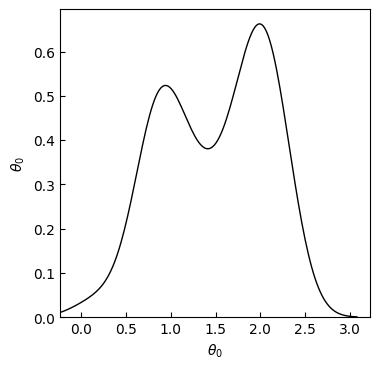

In [3]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.1, size=1.0),
        shift=True
    )
)
figure.plot(data_list=[x[:, jnp.newaxis]])

In [4]:
k = 2
def model(data):
    weights = numpyro.sample("weights", distributions.Dirichlet(0.5 * jnp.ones(k)))
    
    with numpyro.plate("components", k):
        parameters = numpyro.sample("parameters", distributions.MultivariateNormal(jnp.zeros(2), jnp.eye(2)))
        # TODO: Make scale positive
    
    with numpyro.plate("data", len(data)):
        assignment = numpyro.sample("assignment", distributions.Categorical(weights), infer={"enumerate": "parallel"})
        return numpyro.sample("obs", distributions.Normal(parameters[assignment, 0], parameters[assignment, 1]), obs=data)

In [5]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(model).get_trace(x)
print(numpyro.util.format_shapes(trace))

   Trace Shapes:        
    Param Sites:        
   Sample Sites:        
    weights dist     | 2
           value     | 2
components plate   2 |  
 parameters dist   2 | 2
           value   2 | 2
      data plate 100 |  
 assignment dist 100 |  
           value 100 |  
        obs dist 100 |  
           value 100 |  


In [6]:
samples = run(
    rng_key=rng_key_,
    model_posterior_scaled=model,
    data=x,
    num_warmup=1024,
    num_samples_total=2**12,
    num_chains=2**4
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:02<00:00,  3.88s/it]


In [7]:
samples_parameters = samples["parameters"].reshape((-1, 2 * k), order="F")
for key in samples.keys():
    print(key)

parameters
weights


(4096, 4)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.81it/s]


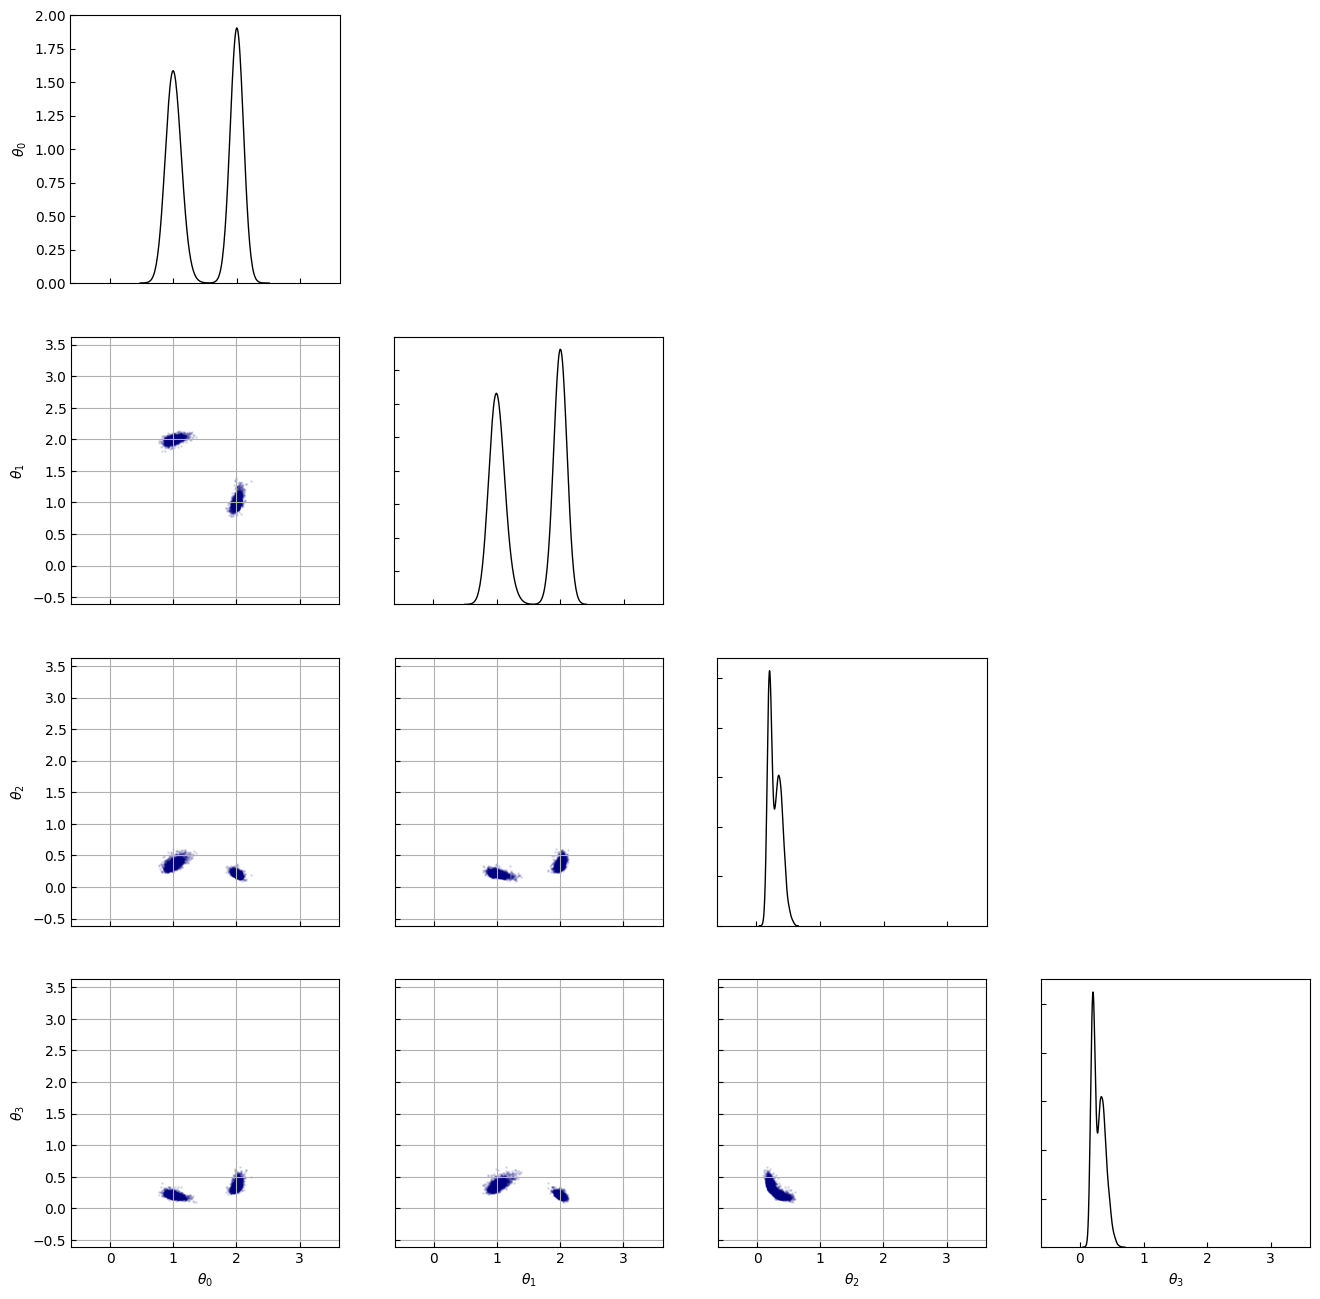

In [8]:
print(samples_parameters.shape)
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.1, size=1.0),
        shift=True
    )
)
figure.plot(data_list=[samples_parameters])

In [9]:
sele_1 = np.argwhere((samples_parameters[:, 1] <= 1.5) * 1.0).squeeze()
sele_2 = np.argwhere((samples_parameters[:, 1] > 1.5) * 1.0).squeeze()
subset_1 = samples_parameters[sele_1]
subset_2 = samples_parameters[sele_2]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.74it/s]


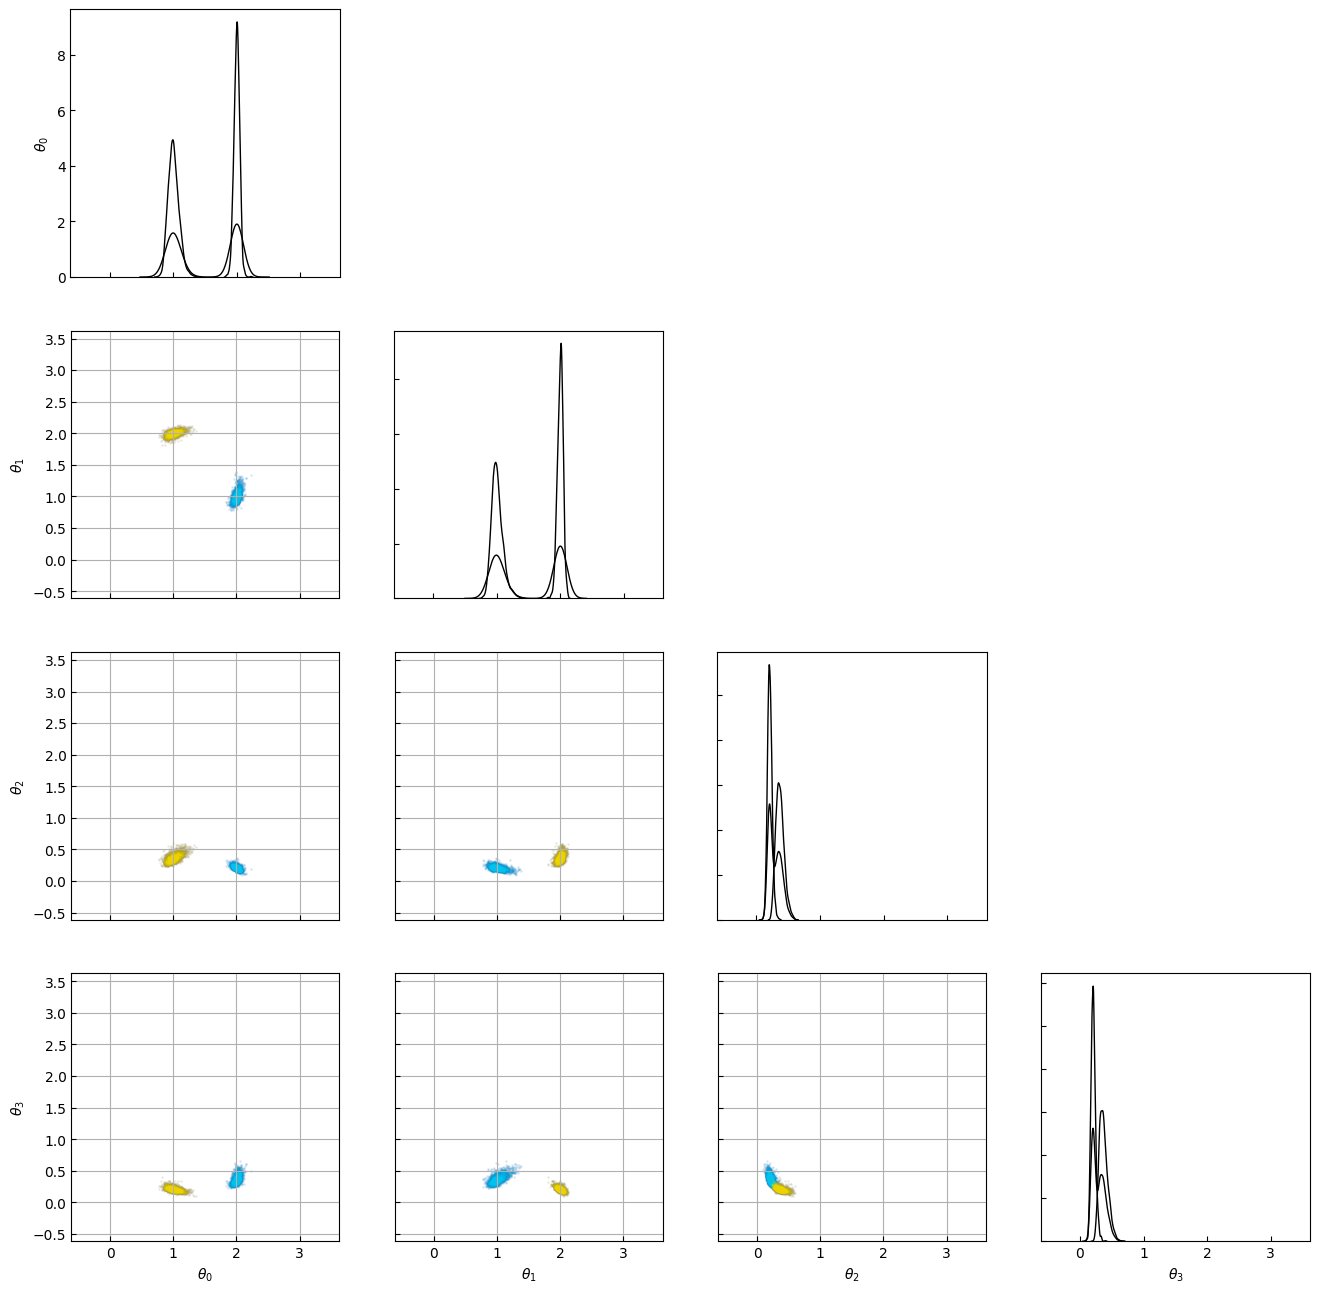

In [10]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=0.05, size=1.0),
        shift=True
    )
)
figure.plot(data_list=[samples_parameters, subset_1, subset_2])